<a href="https://colab.research.google.com/github/sarthak4002/srm-repo/blob/main/SarthakProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # This will open a file upload dialog. Select kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarthakpandeynhjh","key":"e6e7c0c21c1d59c25ae4ae0b1d8d65e1"}'}

In [2]:
!pip install kaggle  # Install Kaggle API
!mkdir -p ~/.kaggle  # Create .kaggle directory
!cp kaggle.json ~/.kaggle/  # Move kaggle.json to the .kaggle directory
!chmod 600 ~/.kaggle/kaggle.json  # Secure the API key


In [3]:
!kaggle datasets download -d nih-chest-xrays/data -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
100% 42.0G/42.0G [08:19<00:00, 20.1MB/s]
100% 42.0G/42.0G [08:19<00:00, 90.2MB/s]
User cancelled operation


Metadata Head:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.14

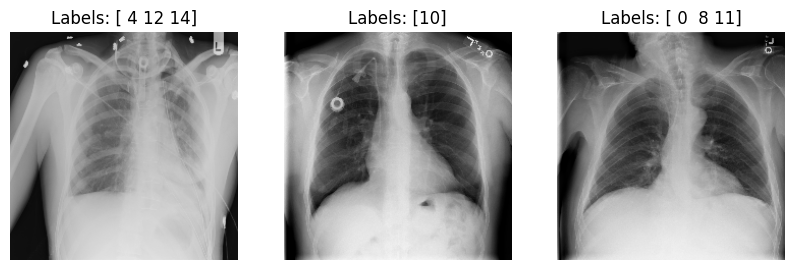

Validation Samples:


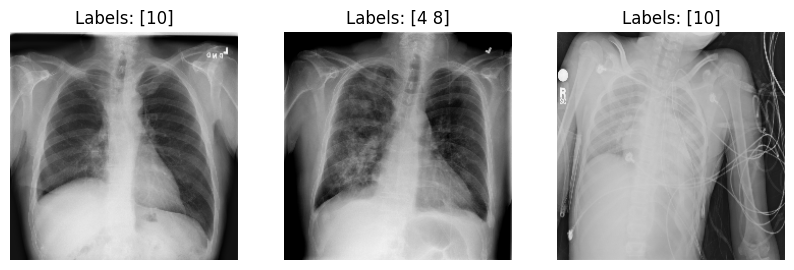

In [4]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Load the Metadata (CSV)
metadata_path = "/content/Data_Entry_2017.csv"  # Path to your metadata file
metadata = pd.read_csv(metadata_path)

# Display metadata to check the columns
print("Metadata Head:")
print(metadata.head())

# Step 2: Extract Image Paths and Labels
base_dir = "/content"  # Path to the root dataset folder (update if necessary)

image_paths = []
labels = []

# Iterate through image folders (images_01, images_02, ..., images_12)
for folder in os.listdir(base_dir):
    if folder.startswith("images_"):  # Only consider folders starting with 'images_'
        folder_path = os.path.join(base_dir, folder, "images")  # Path to the 'images' folder
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                if image_file.endswith(".png"):  # Only consider .png files
                    image_path = os.path.join(folder_path, image_file)
                    image_paths.append(image_path)

                    # Extract label from metadata
                    label = metadata.loc[metadata["Image Index"] == image_file, "Finding Labels"].values[0]
                    labels.append(label)

# Check how many images and labels were found
print(f"Total images found: {len(image_paths)}")
print(f"Total labels found: {len(labels)}")

# Step 3: Preprocess Labels (Multi-Label Binarization)
# Convert labels into a list of lists (splitting multi-label cases)
labels = [label.split("|") for label in labels]

# Use MultiLabelBinarizer to convert labels into a binary matrix
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

# Print all disease classes
print("\nClasses:", mlb.classes_)

# Step 4: Split Data into Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# Step 5: Create Data Generator for TensorFlow Datasets
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Decode PNG image
    image = tf.image.resize(image, [224, 224])  # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
    return image, label

BATCH_SIZE = 32

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(load_and_preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.map(load_and_preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Step 6: Verify Preprocessing (Display some samples)
def display_samples(dataset, num_samples=3):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(images[i])
            plt.title(f"Labels: {np.where(labels[i] == 1)[0]}")
            plt.axis('off')
        plt.show()

print("\nTraining Samples:")
display_samples(train_dataset)

print("Validation Samples:")
display_samples(val_dataset)

